<a href="https://colab.research.google.com/github/ikram-hamizi/AML-DS-2021/blob/main/Midterm_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <center>Midterm Lab
```
- Advanced Machine Learning, Innopolis University 
- Professor: Muhammad Fahim 
- Teaching Assistant: Gcinizwe Dlamini
```
<hr>

```
Tasks:
  1. Image Transform (5 points)
  2. CNN model declaration (10 points)
  3. CNN model training (5 points)
  4. Transfer Learning or Viterbi algorithm : Bonus (5 points)
```

<hr>

## The Dataset

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Task 1 : Preprocessing of Dataset (5 points)

1.   Create the transforms:
    * Resize images to (32 * 32)
    * Normalize every channel (mean and std of your choice)
    * Apply one more data augmentation technique you know (i.e Rotation, translation, RandomErasing, RandomHorizontalFlip etc.)


**Hint**: data augmentation techniques shouldn't be applied to the test dataset.

In [18]:
import torchvision.transforms as transforms

transform_train = transforms.Compose(
    [transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.RandomHorizontalFlip(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose(
    [transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

trainset = torchvision.datasets.SVHN(root='./data/train', split="train", download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)

testset = torchvision.datasets.SVHN(root='./data/test', split="test", download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=1)

classes = [f"{i}" for i in np.unique(trainset.labels)]

Using downloaded and verified file: ./data/train/train_32x32.mat
Using downloaded and verified file: ./data/test/test_32x32.mat


## Task 1.1 Plot Classes distribution 

Plot the distribution of classes in the training sample on a bar graph

In [109]:
train_classes = [label for _, label in trainset]

In [113]:
len(np.unique(np.array(train_classes)))

10

(array([ 4948., 13861., 10585.,  8497.,  7458.,  6882.,  5727.,  5595.,
         5045.,  4659.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

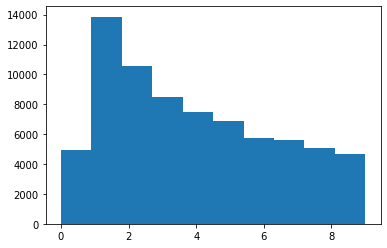

In [114]:
plt.hist(train_classes)

In [88]:
from matplotlib import pyplot as plt

#TODO: Plot the distribution of classes
all_labels = []
import matplotlib.pyplot as plt
for batch_idx, (inputs, labels) in enumerate(trainloader):
     all_labels.append(labels)

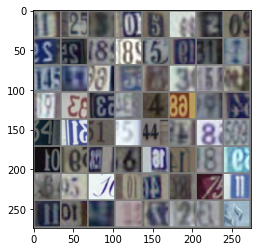

In [19]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 32, 32)
    return x

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# sample a batch and show 
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

## Task 2 : Build a classisfication convolutional neural network


The Model should should have the following achitecture : 
1. 3 Convolution layers : (5 points)
    * conv1 : 2 kernels, 3*3 kernel size, stride 1.
    * conv2 : 4 kernels, 5*5 kernel size, stride 2.
    * conv3 : 8 kernels, 3*3 kernel size, stride 1.
    * Add 1 Avarage pooling layer after 2nd layer and 1 Max-pooling layer before the fully connected layers.
    * Stride for all pooling operations set to 1 
    
    
2. Fully connected layers : 
    * fc1 : 64 output-neurons with a relu activation.
    * output_layer : final layer with no activation function
    * Add Dropout layer after the first (fc1) layer with 25% dropout probability

3. Implement the foward pass method for the CNN  (5 points)
    * Add an activation function of your own choice after every layer
    

In [129]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #TODO: Declare the model layers
        self.conv1 = nn.Conv2d(3, 2, 3, stride=1)  # 3 input image channel, 2 output channels, 3x3 square convolution
        self.conv2 = nn.Conv2d(2, 4, 5, stride=2)
        self.pool1 = nn.AvgPool2d(2, 2)
        self.conv3 = nn.Conv2d(4, 8, 3, stride=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(8 * 2 * 2, 64)
        self.dpout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # TODO: Implement the forward pass
        x = self.pool1(F.relu(self.conv1(x))); #print("conv1",x.shape)
        x = F.relu(self.conv2(x)); #print("conv2",x.shape)
        x = self.pool2(F.relu(self.conv3(x))); #print("conv3",x.shape)
        x = x.view(-1, 8*2*2) # flatten the output of previous layer using x.view(...)
        x = self.dpout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
        #return #None

## Task 3 : Convolutional neural network training precedure (5 points)

Implement the model training procedure and select the appropriate loss function

In [48]:
# Model accuracy calculator 
def accuracy_calc(net,testloader,device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total

In [131]:
model = Net().to(device)

In [121]:
model

Net(
  (conv1): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(2, 4, kernel_size=(5, 5), stride=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (dpout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [125]:
#Set hyper parameters 
nb_epoch = 3
lr = 0.001


optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss() #TODO: Define the Loss function (criterion)

def train(net,trainloader,optimizer, criterion, device):
    #TODO : Implement the training procedure of the model at each an every epoch. It should return model loss and accuracy on training sample
    for epoch in range(1):  # loop over the dataset multiple times
        
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    # print images
    imshow(torchvision.utils.make_grid(images))
    plt.show()
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
    images, labels = images.to(device), labels.to(device)
    outputs = net(images).cuda()
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                for j in range(4)))
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

    return "no value", "no value"

Finished Training


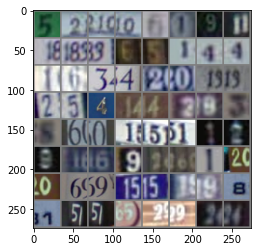

GroundTruth:      5     2     1     0
Predicted:      8     8     8     2
Accuracy of the network on the 10000 test images: 9 %
Accuracy of     0 :  0 %
Accuracy of     1 :  0 %
Accuracy of     2 : 28 %
Accuracy of     3 :  0 %
Accuracy of     4 :  0 %
Accuracy of     5 :  0 %
Accuracy of     6 :  0 %
Accuracy of     7 :  0 %
Accuracy of     8 : 66 %
Accuracy of     9 :  0 %
Epoch : 0, Loss no value, Accuracy no value
Finished Training


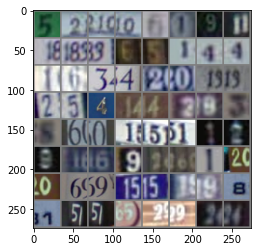

GroundTruth:      5     2     1     0
Predicted:      8     8     8     8
Accuracy of the network on the 10000 test images: 9 %
Accuracy of     0 :  0 %
Accuracy of     1 :  0 %
Accuracy of     2 : 32 %
Accuracy of     3 :  0 %
Accuracy of     4 :  0 %
Accuracy of     5 :  0 %
Accuracy of     6 :  0 %
Accuracy of     7 :  0 %
Accuracy of     8 : 58 %
Accuracy of     9 :  0 %
Epoch : 1, Loss no value, Accuracy no value
Finished Training


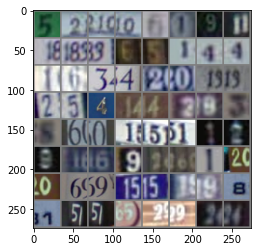

GroundTruth:      5     2     1     0
Predicted:      2     8     8     2
Accuracy of the network on the 10000 test images: 9 %
Accuracy of     0 :  0 %
Accuracy of     1 :  0 %
Accuracy of     2 : 29 %
Accuracy of     3 :  0 %
Accuracy of     4 :  0 %
Accuracy of     5 :  0 %
Accuracy of     6 :  3 %
Accuracy of     7 :  0 %
Accuracy of     8 : 67 %
Accuracy of     9 :  0 %
Epoch : 2, Loss no value, Accuracy no value


In [132]:
for epoch in range(nb_epoch):
    epochLoss, epochAcc = train(model,trainloader, optimizer, criterion, device)
    print(f"Epoch : {epoch}, Loss {epochLoss}, Accuracy {epochAcc}")

## Task 4 (bonus) : Use pretrained CNN model or Viterbi implementation (5 points)

**Option 1** : Import any pretrained model and train on CIFAR10. Print out the loss and accuracy at each an every epoch. Number of training epochs and optimizer are of your choice. <br>
**OPtion 2** : Implement the viterbi algorithm (from previous lab task POS tagging) 

In [ ]:
!pip install wget

from time import time
import pandas as pd
import wget

# 1. GET DATA
wget.download('https://raw.githubusercontent.com/Gci04/AML-DS-2021/main/data/PosTagging/train_pos.txt')
wget.download('https://raw.githubusercontent.com/Gci04/AML-DS-2021/main/data/PosTagging/test_pos.txt')

In [72]:
names = ['Word', 'Tag']
train = pd.read_csv("train_pos.txt", sep=" ", names=names) #a modified conll2000 dataset
test = pd.read_csv("test_pos.txt", sep=" ", names=names)

train = train.astype(str)
test = test.astype(str)

In [73]:
train.head()

,Word,Tag
0,Confidence,NN
1,in,IN
2,the,DT
3,pound,NN
4,is,VBZ


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


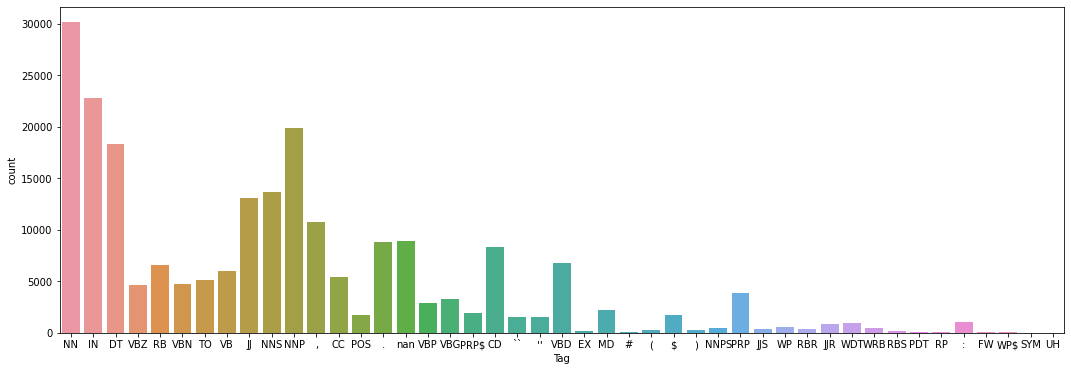

In [74]:
# 2. GET INDEX OF TAGS
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_y_enc = label_encoder.fit_transform(train['Tag'])
tags_index = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))) #INDEX {tag:int} #starts from 1
tags_index_size = len(tags_index) 

# variables
unique_tags = train['Tag'].unique()
unique_words = train['Word'].unique()
total_words = len(unique_words)
total_tags = len(unique_tags) #len(unique_tags)

# 3. Visualize
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(18,6))
sns.countplot(train['Tag'])

# 3. split to x and y
train_x = train['Word']
train_y = train['Tag'].to_numpy()

test_x = test['Word']
test_y = test['Tag'].to_numpy()

In [75]:
import csv
from keras.utils import np_utils 

def sentence_tags_to_vector(sentence_tags, tags_index):
  vector = []
  for tag in sentence_tags:
    if tag in tags_index:
      vector.append(tags_index[tag])
    else:
      vector.append(-999)
  return vector

#Function: transforms dataset to a table of sentences and their corresebonding sequences of tags
def transform_to_sentence_tags_table(file_path, numerical_labels=False, ohe_labels=False, sen_maxlen=100):

  sentences_list = []
  tags_list = []

  sentence = []
  sentence_tags = []

  i=0
  with open(file_path, "r") as file:
    csv_reader = csv.reader(file, delimiter=' ')

    for line in csv_reader:
      i+=1  
      if len(line[0])==0 or line[0]==" ":
        
        if i>1:
          #Create sentence
          sentences_list.append(sentence)

          #Create list of tags

          if ohe_labels or numerical_labels:
            numerical_vector = sentence_tags_to_vector(sentence_tags, tags_index)
            if ohe_labels:
              padded_vector = pad_sequences([numerical_vector], padding='post', maxlen=sen_maxlen)
              ohe_matrix = np_utils.to_categorical(padded_vector, num_classes=len(tags_index), dtype=np.float64)
              tags_list.append(ohe_matrix)
            elif numerical_labels:
              padded_vector = pad_sequences([numerical_vector], padding='post', maxlen=len(tags_index))
              tags_list.append(padded_vector)
          elif not ohe_labels and not numerical_labels:
            tags_list.append(sentence_tags)

        #Reset
        sentence = []
        sentence_tags = []

      else:
        sentence.append(line[0])
        sentence_tags.append(line[1])

  df_sentences = pd.DataFrame(list(zip(sentences_list, tags_list)), columns=['Sentence', 'Tag'])
  return df_sentences

train_sentences = transform_to_sentence_tags_table('train_pos.txt')
test_sentences = transform_to_sentence_tags_table('test_pos.txt')

### **Task 1**: Calculate the transition probability and emission matrices 
This is the First step towards viterbi.

In [76]:
from collections import Counter

agg_dict = {'Tag':Counter}
train_agg = train.groupby(by=['Word'], as_index=False).agg(agg_dict)

In [77]:
from tqdm import tqdm 

"""1. Func: get prior probabilities"""
def get_priors():
  priors = np.empty(total_tags) #vector

  counts = train['Tag'].value_counts()
  total = sum(counts) # = 220663 = len(train)

  priors = counts/total
  return priors


"""2. Func: get EMISSIONS probabilities matrix"""

#helper function
def get_emission_proba_vector(word):
  #1. GET COUNTS
  tags_counts = dict.fromkeys(unique_tags.tolist(),1e-8) #initialize dict with keys (unique tags)
  word_sample_space_count = 0

  #Join the two columns by word. The tag column becomes a counter of tags 
  tag_counter_of_word = list(train_agg[train_agg['Word']==word].to_numpy()[0][1].items())
  for tag_counter in tag_counter_of_word:
    tags_counts[tag_counter[0]] += tag_counter[1]
    word_sample_space_count += tag_counter[1]

  #2. GET PROBAS
  word_probs_vector = list(tags_counts.values())
  if word_sample_space_count is not 0:
    word_probs_vector = [w/word_sample_space_count for w in word_probs_vector]

  return word_probs_vector

#EMISSIONS
def get_emissions_matrix():
  emissions = np.empty((total_words, total_tags)) #matrix'

  with tqdm(total=total_words) as pbar:
    for i, word in enumerate(unique_words):
      emissions[i] = get_emission_proba_vector(word) # P(ti|tj)
      pbar.update()

  return emissions



"""3. Func: get transition probabilities matrix"""

#helper function
def get_trans_proba_vector(tag):

  tags_counts = dict.fromkeys(unique_tags.tolist(),1e-8) #initialize dict with keys (unique tags)
  tags_rows = train_sentences['Tag']

  #1. GET COUNTS
  for list_of_tags in tags_rows: #for each list of tags in a row

    if tag not in list_of_tags: continue;  
    else: i = list_of_tags.index(tag) #index of our tag
    
    for iter in range(len(list_of_tags)):#for each tag present in the row
      if i+1>=len(list_of_tags): break;

      next_tag = list_of_tags[i+1:][0] #get the tag that appears after our desired tag
      if 0>=i+1>=len(list_of_tags): break

      if (list_of_tags[i]==tag): #if the previous tag (i) is our tag, increment the count of our current one
        tags_counts[next_tag]+=1

      if tag not in list_of_tags[i+1:]: break;
      else: i += list_of_tags[i+1:].index(tag)+1; 

  tags_probs_vector = list(tags_counts.values())
  
  #2. GET PROBAS
  tag_sample_space_count =  sum(tags_probs_vector)
  tags_probs_vector = [t/tag_sample_space_count for t in tags_probs_vector] if tag_sample_space_count is not 0 else tags_probs_vector

  return tags_probs_vector

#TRANSITION
def get_transitions_matrix():
  transitions = np.zeros((total_tags, total_tags), dtype='float32') #matrix

  with tqdm(total=total_tags) as pbar:
    for i, tag in enumerate(unique_tags):
        transitions[i] = get_trans_proba_vector(tag) # P(ti|tj)
        pbar.update()

  return transitions

In [78]:
#1. Prior Probabilities Pi: P(ti)
priors = get_priors() #vector

#2. Emission Probabilities: P(wi|ti)
emissions = get_emissions_matrix() #matrix

#3. Transision Probabilities: P(ti|ti-1)
transitions = get_transitions_matrix() #matrix

100%|██████████| 45/45 [00:00<00:00, 88.12it/s]


In [79]:
#convert the two matrices to dataframes
emissions_df = pd.DataFrame(emissions, columns=unique_tags, index=unique_words)
transitions_df = pd.DataFrame(transitions, columns=unique_tags, index=unique_tags)
transitions_df.head()

,NN,IN,DT,VBZ,RB,VBN,TO,VB,JJ,NNS,NNP,",",CC,POS,.,nan,VBP,VBG,PRP$,CD,``,'',VBD,EX,MD,#,(,$,),NNPS,PRP,JJS,WP,RBR,JJR,WDT,WRB,RBS,PDT,RP,:,FW,WP$,SYM,UH
NN,0.117678,0.247835,0.007699,0.038795,0.017058,0.012080,0.041483,0.001427,0.009956,0.084990,0.009724,0.112534,0.039724,2.203564e-02,0.105731,3.318621e-13,0.003650,0.007898,0.000166,0.005343,0.002190,5.210235e-03,0.048651,3.318621e-04,0.018186,3.318621e-05,0.001792,0.000498,2.024359e-03,2.986759e-04,0.005277,3.318621e-13,0.002456,0.003850,0.001327,0.007865,1.991173e-03,0.000199,3.318621e-05,6.637241e-05,0.011482,1.659310e-04,1.991172e-04,6.637241e-05,3.318621e-13
IN,0.111560,0.029746,0.326245,0.001318,0.014983,0.005844,0.003427,0.000439,0.084186,0.061470,0.136737,0.004482,0.001801,4.393866e-13,0.000791,4.393866e-13,0.000352,0.027725,0.036689,0.062129,0.006064,5.272640e-04,0.000176,1.449976e-03,0.000176,7.030186e-04,0.000439,0.027857,4.393866e-05,1.889362e-03,0.030801,3.031768e-03,0.002417,0.000483,0.005361,0.003251,1.713608e-03,0.001801,1.230282e-03,4.393866e-13,0.000439,2.196933e-04,4.393866e-13,4.393866e-13,4.393866e-13
DT,0.484591,0.008237,0.001309,0.008891,0.010909,0.015600,0.000273,0.000764,0.198931,0.073201,0.111002,0.002345,0.001036,5.454644e-13,0.001745,5.454644e-13,0.000927,0.010091,0.000436,0.025746,0.004909,5.454644e-13,0.003218,5.454644e-13,0.001745,3.272787e-04,0.000436,0.008455,1.090929e-04,2.127311e-03,0.000764,9.327442e-03,0.000655,0.001364,0.006382,0.000218,5.454644e-13,0.003055,5.454644e-13,5.454644e-13,0.000491,1.636393e-04,5.454644e-13,5.454644e-13,2.181858e-04
VBZ,0.039595,0.095976,0.168496,0.001506,0.134495,0.144609,0.045406,0.002582,0.075963,0.017215,0.061760,0.027975,0.003658,2.151926e-12,0.029051,2.151926e-12,0.001291,0.051216,0.010114,0.017861,0.008393,2.151926e-12,0.003443,8.607704e-04,0.001722,2.151926e-12,0.000215,0.004519,2.151926e-12,2.151926e-12,0.022380,4.303852e-04,0.002582,0.002152,0.007962,0.000646,7.746933e-03,0.001506,2.151926e-04,1.506348e-03,0.004949,2.151926e-12,2.151926e-12,2.151926e-12,2.151926e-12
RB,0.008023,0.129276,0.050711,0.041023,0.058886,0.086285,0.025431,0.109749,0.102785,0.004995,0.006812,0.093249,0.007115,4.541326e-04,0.062519,1.513775e-12,0.031184,0.030730,0.002725,0.022858,0.001060,1.059643e-03,0.050560,6.055101e-04,0.011505,3.027551e-04,0.000151,0.015289,1.513775e-04,3.027551e-04,0.011202,6.055101e-04,0.001665,0.004693,0.017408,0.000454,3.481683e-03,0.000303,4.541326e-04,1.513775e-12,0.003784,1.513775e-04,1.513775e-12,1.513775e-12,1.513775e-12


In [80]:
emissions_df.head()

,NN,IN,DT,VBZ,RB,VBN,TO,VB,JJ,NNS,NNP,",",CC,POS,.,nan,VBP,VBG,PRP$,CD,``,'',VBD,EX,MD,#,(,$,),NNPS,PRP,JJS,WP,RBR,JJR,WDT,WRB,RBS,PDT,RP,:,FW,WP$,SYM,UH
Confidence,1.000000e+00,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08
in,4.414361e-03,9.935256e-01,2.942908e-12,2.942908e-12,2.060035e-03,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12
the,1.084716e-12,1.844018e-03,9.981560e-01,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12
pound,1.000000e+00,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10
is,7.067138e-12,7.067138e-12,7.067138e-12,9.978799e-01,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,2.120141e-03,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12


### **Task 2**: Implement Viterbi Algorithm for POS-Tagging

In [81]:
import numpy as np

def viterbi(sentence, emissions_df, transitions_df, priors):
  
  number_of_words = len(sentence)
  total_tags = len(transitions)
  
  highest_prob_so_far = 1

  best_states_vector = np.zeros(number_of_words, dtype=object) #states are strings (tags)
  viterbi_matrix = np.zeros((total_tags, number_of_words))

  for i, word in enumerate(sentence):
    # multiply: highest_prob_so_far*p(wi|tags)*p(previous_tag); i.e.
    # multiply: highest_prob_so_far_value * emissions(word)_vector * transitions(previous_tag)_vector
    
    if word not in emissions_df.index:
      word = 'nan'

    emissions_word = emissions_df.loc[word,:].to_numpy()
    
    if i==0: #initialize: use priors instead of highest_prob_so_far
      viterbi_matrix[:,i] = np.log10(priors) + np.log10(emissions_word)
    else:
      transitions_tag = transitions_df.loc[best_states_vector[i-1],:].to_numpy()
      viterbi_matrix[:,i] = np.log10(highest_prob_so_far)+np.log10(emissions_word)+np.log10(transitions_tag)
      
    highest_prob_so_far = pow(10, max(viterbi_matrix[:,i]))
    highest_prob_so_far_index = np.argmax(viterbi_matrix[:,i]) #index = tag_number_representation
    best_states_vector[i] = unique_tags[highest_prob_so_far_index] 

  return best_states_vector #most likely path

In [82]:
def viterbi_predict(test_x):
  pred_y = []

  with tqdm(total=len(test_x)) as pbar:
    for sentence in test_x:
      pred_y.append(viterbi(sentence, emissions_df, transitions_df, priors))
      pbar.update()

  return pred_y

In [83]:
def accuracy(y_test, y_pred):
  avg_accuracy = 0
  for test_instance, pred_instance in list(zip(y_test, y_pred)):
    correct = [y1 for y1, y2 in list(zip(test_instance, pred_instance)) if y1 == y2] 
    avg_accuracy += len(correct)/float(len(test_instance))/float(len(y_test))
    
  return avg_accuracy

In [84]:
test_x_viterbi = test_sentences['Sentence'].to_numpy()
test_y_viterbi = test_sentences['Tag'].to_numpy()

start_viterbi = time()
pred_y_viterbi = viterbi_predict(test_x_viterbi)
end_viterbi = time()
total_viterbi = end_viterbi - start_viterbi

print(f"\n1. Viterbi Accuracy = {accuracy(test_y_viterbi, pred_y_viterbi)}%")
print(f"Time to finish: {total_viterbi} seconds")

100%|██████████| 2012/2012 [00:12<00:00, 161.11it/s]


1. Viterbi Accuracy = 0.8994715519094878%
Time to finish: 12.492066860198975 seconds
